Jason Bhalla

The goal of this stage of the project is to take random subsets of Z^2, perform random "gluings" to "fold" the flat surface into more of a torus-like shape, and then comparing the soficity score with the ball of radius *r* (meaning, finding the percentage of points that look identical to Z^2 with a ball of radius *r*, both before and after the gluings). Here, I am investigating different methods of breaking up Z^2 and performing the gluings to see which methods have the best improvement in score.

The big-picture goal for the project is identifying a process for generating the best possible sofic approximations for a given group.

### Version 1: Fully-Random Cross-Rectangle Gluing

Sample 0: before=0.414, after=0.482, Δ=0.068
Sample 1: before=0.545, after=0.598, Δ=0.052
Sample 2: before=0.449, after=0.508, Δ=0.059
Sample 3: before=0.521, after=0.575, Δ=0.054
Sample 4: before=0.447, after=0.502, Δ=0.055
Sample 5: before=0.426, after=0.489, Δ=0.063
Sample 6: before=0.409, after=0.453, Δ=0.044
Sample 7: before=0.522, after=0.573, Δ=0.051
Sample 8: before=0.500, after=0.549, Δ=0.049
Sample 9: before=0.561, after=0.612, Δ=0.051
Sample 10: before=0.519, after=0.586, Δ=0.067
Sample 11: before=0.474, after=0.545, Δ=0.071
Sample 12: before=0.431, after=0.498, Δ=0.067
Sample 13: before=0.544, after=0.594, Δ=0.049
Sample 14: before=0.568, after=0.613, Δ=0.045
Sample 15: before=0.431, after=0.485, Δ=0.053
Sample 16: before=0.472, after=0.551, Δ=0.079
Sample 17: before=0.501, after=0.560, Δ=0.059
Sample 18: before=0.545, after=0.595, Δ=0.050
Sample 19: before=0.499, after=0.556, Δ=0.058
Sample 20: before=0.500, after=0.569, Δ=0.069
Sample 21: before=0.532, after=0.595, Δ=0.06

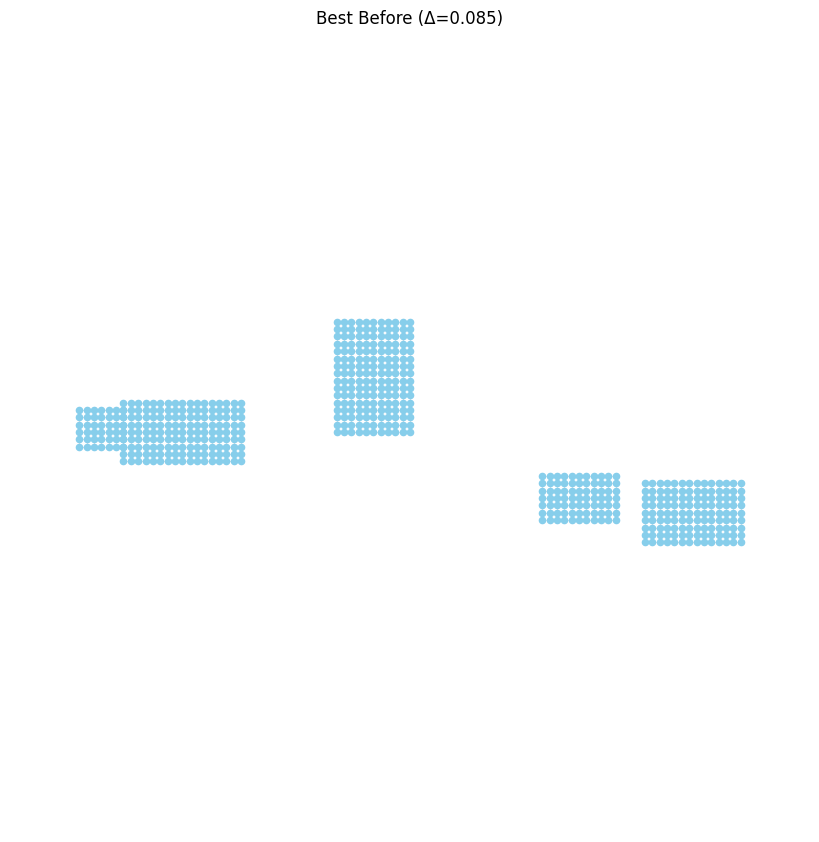

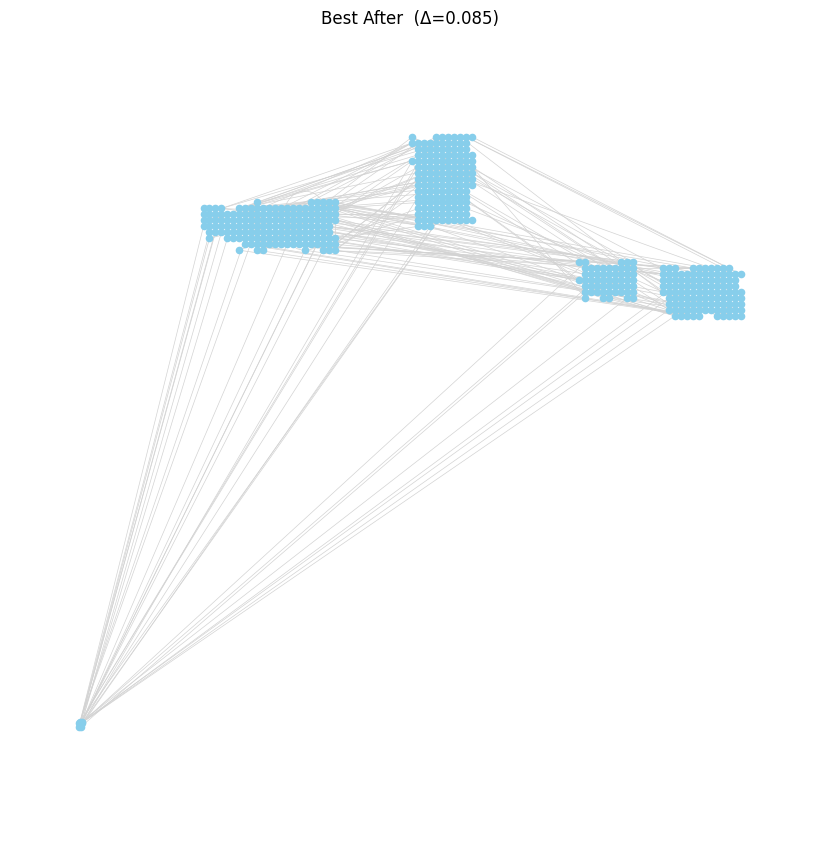


Constructed PatternBoost dataset with 50 entries.
Top 12 entries (25%):
  score=0.613, token_length=718201
  score=0.613, token_length=746031
  score=0.612, token_length=717003
  score=0.606, token_length=567645
  score=0.603, token_length=634501
  score=0.601, token_length=569778
  score=0.598, token_length=539241
  score=0.595, token_length=502503
  score=0.595, token_length=452676
  score=0.594, token_length=659526
  score=0.590, token_length=578350
  score=0.586, token_length=432915


In [ ]:
"""
Version 1 – Fully‑Random Cross‑Rectangle Gluing

- Boundary pools:

  - Gathers all horizontal edges (tops + bottoms) from every rectangle into one list.

  - Gathers all vertical edges (lefts + rights) into another.

- Pairing strategy:

  - Shuffle each pool and pair sequentially in chunks of two—so you may glue top→top, bottom→bottom, or top→bottom, and edges can come from any rectangles.

  - Attempts up to N_HORIZONTAL_GLUINGS horizontal pairs and N_VERTICAL_GLUINGS vertical pairs.

- Edge reuse:

  - Does not remove or mark edges once they’ve been paired; the same boundary edge could in principle be selected again in further iterations.

- Inter‑rectangle:

  - Freely matches edges across different rectangles (and even within the same rectangle).

- Merge operation:

  - Uses vertex identification: for each paired edge ((a₁,a₂),(b₁,b₂)), replaces every occurrence of b₁→a₁ and b₂→a₂, preserving all original adjacency.


"""

import math
import random
import itertools
import collections

import networkx as nx
import matplotlib.pyplot as plt

from dataclasses import dataclass, field
from typing import List, Tuple, Dict, Set, Optional

# ==============================
# CONFIG / PARAMETERS
# ==============================
SEED = 40
random.seed(SEED)

CANVAS_WIDTH = 150
CANVAS_HEIGHT = 150

# Number of rectangular subgraphs (rectangles of tiles) to generate
N_RECTANGLES = 5

# Rectangle side ranges (in # of tiles)
MIN_SIDE = 5
MAX_SIDE = 20

# Radius r for local isomorphism scoring (ball radius in graph distance)
RADIUS = 2

# Number of random gluings to attempt for horizontal and vertical boundary edge sets
N_HORIZONTAL_GLUINGS = 30     # (top/bottom edges)
N_VERTICAL_GLUINGS = 30       # (left/right edges)

# Whether to visualize intermediate steps
VISUALIZE = True

# ==============================
# DATA STRUCTURES
# ==============================
@dataclass
class Tile:
    """
    A tile is a unit square in Z^2 with 4 directed-cyclically ordered vertices:
      (top-left, top-right, bottom-right, bottom-left)
    """
    vertices: Tuple[int, int, int, int]
    coord: Tuple[int, int]

@dataclass
class RectangleSubgraph:
    """
    Represents a rectangular collection of tiles (w x h).
    """
    tiles: List[Tile]
    width: int
    height: int
    origin: Tuple[int, int]
    id: int

@dataclass
class GluingRecord:
    """
    Record for each edge identification/gluing.
    """
    tile_a: int
    tile_b: int
    edge_type: str
    old_edge_a: Tuple[int, int]
    old_edge_b: Tuple[int, int]
    new_edge: Tuple[int, int]

# ==============================
# GLOBAL STATE
# ==============================
class SoficApproximation:
    def __init__(self):
        self.rectangles: List[RectangleSubgraph] = []
        self.tiles: List[Tile] = []
        self.vertex_positions: Dict[int, Tuple[float, float]] = {}
        self.next_vertex_id = 1
        self.gluings: List[GluingRecord] = []

    def _new_vertex(self, x: float, y: float) -> int:
        vid = self.next_vertex_id
        self.next_vertex_id += 1
        self.vertex_positions[vid] = (x, y)
        return vid

    def _ensure_vertex(self, pos_to_vid: Dict[Tuple[float,float], int], x: float, y: float) -> int:
        key = (x, y)
        if key in pos_to_vid:
            return pos_to_vid[key]
        vid = self._new_vertex(x, y)
        pos_to_vid[key] = vid
        return vid

    def add_rectangle(self, rect_id: int, origin: Tuple[int,int], w: int, h: int, tile_size: float=1.0):
        """
        Place a w x h block of tiles at 'origin'.
        """
        ox, oy = origin
        local_map: Dict[Tuple[float,float],int] = {}
        tiles = []
        for ty in range(h):
            for tx in range(w):
                gx, gy = ox + tx, oy + ty
                tl = self._ensure_vertex(local_map, gx*tile_size,     gy*tile_size)
                tr = self._ensure_vertex(local_map, (gx+1)*tile_size, gy*tile_size)
                br = self._ensure_vertex(local_map, (gx+1)*tile_size, (gy+1)*tile_size)
                bl = self._ensure_vertex(local_map, gx*tile_size,     (gy+1)*tile_size)
                tiles.append(Tile(vertices=(tl, tr, br, bl), coord=(gx, gy)))
        self.tiles.extend(tiles)
        self.rectangles.append(RectangleSubgraph(tiles=tiles, width=w, height=h, origin=origin, id=rect_id))

    def rectangle_boundary_edges(self, rect: RectangleSubgraph):
        """
        Return lists of boundary edges for a rectangle.
        """
        horiz, vert = [], []
        base_idx = self.tiles.index(rect.tiles[0])
        coord_to_idx = {t.coord: i for i, t in enumerate(rect.tiles)}
        for i, tile in enumerate(rect.tiles):
            tl, tr, br, bl = tile.vertices
            x, y = tile.coord
            if (x, y-1) not in coord_to_idx:
                horiz.append((base_idx+i, 'top', (tl, tr)))
            if (x, y+1) not in coord_to_idx:
                horiz.append((base_idx+i, 'bottom', (bl, br)))
            if (x-1, y) not in coord_to_idx:
                vert.append((base_idx+i, 'left', (tl, bl)))
            if (x+1, y) not in coord_to_idx:
                vert.append((base_idx+i, 'right', (tr, br)))
        return {'horizontal': horiz, 'vertical': vert}

    def collect_all_boundary_edges(self):
        all_h, all_v = [], []
        for rect in self.rectangles:
            b = self.rectangle_boundary_edges(rect)
            all_h.extend(b['horizontal'])
            all_v.extend(b['vertical'])
        return all_h, all_v

    def glue_edge_pairs(self, edge_pairs, edge_type: str):
        """
        IDENTIFICATION gluing: merge endpoints of the second edge into the first.
        For ((a1,a2),(b1,b2)), we identify b1->a1 and b2->a2 in EVERY tile.
        """
        for (tile_a, name_a, (a1, a2)), (tile_b, name_b, (b1, b2)) in edge_pairs:
            if tile_a == tile_b and name_a == name_b:
                continue
            # Replace b1->a1, b2->a2 in all tiles
            for tile in self.tiles:
                verts = [a1 if v == b1 else (a2 if v == b2 else v) for v in tile.vertices]
                tile.vertices = tuple(verts)
            # Remove old vertices from positions dict
            self.vertex_positions.pop(b1, None)
            self.vertex_positions.pop(b2, None)
            # Record
            self.gluings.append(GluingRecord(
                tile_a=tile_a, tile_b=tile_b,
                edge_type=edge_type,
                old_edge_a=(a1, a2),
                old_edge_b=(b1, b2),
                new_edge=(a1, a2)
            ))

    def perform_random_gluings(self, n_horizontal: int, n_vertical: int):
        horiz, vert = self.collect_all_boundary_edges()
        random.shuffle(horiz)
        random.shuffle(vert)
        pairs_h = [(horiz[i], horiz[i+1]) for i in range(0, min(2*n_horizontal, len(horiz))-1, 2)]
        pairs_v = [(vert[i],   vert[i+1])   for i in range(0, min(2*n_vertical, len(vert))-1, 2)]
        self.glue_edge_pairs(pairs_h, 'horizontal')
        self.glue_edge_pairs(pairs_v, 'vertical')

    def to_graph(self) -> nx.Graph:
        G = nx.Graph()
        for vid, pos in self.vertex_positions.items():
            G.add_node(vid, pos=pos)
        for tile in self.tiles:
            v = tile.vertices
            cycle = [(v[0],v[1]), (v[1],v[2]), (v[2],v[3]), (v[3],v[0])]
            for e in cycle:
                G.add_edge(*e)
        return G

# ==============================
# GENERATE RANDOM RECTANGLES
# ==============================
def generate_random_rectangles(sa: SoficApproximation):
    attempts = 0
    placed = 0
    while placed < N_RECTANGLES and attempts < 500:
        attempts += 1
        w = random.randint(MIN_SIDE, MAX_SIDE)
        h = random.randint(MIN_SIDE, MAX_SIDE)
        ox = random.randint(0, CANVAS_WIDTH - w - 1)
        oy = random.randint(0, CANVAS_HEIGHT - h - 1)
        sa.add_rectangle(rect_id=placed, origin=(ox, oy), w=w, h=h)
        placed += 1
    if placed < N_RECTANGLES:
        print("Warning: fewer rectangles placed than requested.")

# ==============================
# BUILD IDEAL Z^2 BALL MODEL
# ==============================
def build_Z2_ball_graph(radius: int) -> nx.Graph:
    G = nx.Graph()
    for x in range(-radius, radius+1):
        for y in range(-radius, radius+1):
            if abs(x) + abs(y) <= radius:
                G.add_node((x,y))
    for (x,y) in list(G.nodes):
        for dx,dy in [(1,0),(-1,0),(0,1),(0,-1)]:
            if (x+dx,y+dy) in G:
                G.add_edge((x,y),(x+dx,y+dy))
    return G

Z2_MODEL_BALL = build_Z2_ball_graph(RADIUS)

def canonical_form(subgraph: nx.Graph) -> Tuple:
    degs = sorted(d for _,d in subgraph.degree())
    return tuple(degs)

MODEL_CANON = canonical_form(Z2_MODEL_BALL)

def extract_ball(G: nx.Graph, center: int, radius: int) -> nx.Graph:
    nodes = nx.single_source_shortest_path_length(G, center, cutoff=radius).keys()
    return G.subgraph(nodes).copy()

def is_locally_Z2(G: nx.Graph, v: int, radius: int) -> bool:
    ball = extract_ball(G, v, radius)
    if canonical_form(ball) != MODEL_CANON:
        return False
    matcher = nx.isomorphism.GraphMatcher(ball, Z2_MODEL_BALL)
    return matcher.is_isomorphic()

def score_graph_Z2_like(G: nx.Graph, radius: int) -> float:
    good = sum(1 for v in G.nodes if is_locally_Z2(G, v, radius))
    return good / G.number_of_nodes() if G.number_of_nodes() else 0.0

# ==============================
# VISUALIZATION
# ==============================
def plot_graph(G: nx.Graph, title: str, highlight: Optional[Set[int]]=None):
    pos = {n: G.nodes[n].get('pos',(random.random(),random.random())) for n in G.nodes}
    plt.figure(figsize=(8,8))
    nx.draw(G, pos, node_size=20,
            node_color='skyblue',
            edge_color='lightgray',
            width=0.5,
            with_labels=False)
    if highlight:
        nx.draw_networkx_nodes(G, pos, nodelist=list(highlight),
                               node_color='red', node_size=40)
    plt.title(title)
    plt.axis('equal')
    plt.show()

# ==============================
# PIPELINE (Single Sample)
# ==============================
def generate_sample(glue_horizontal=N_HORIZONTAL_GLUINGS,
                    glue_vertical=N_VERTICAL_GLUINGS,
                    visualize=VISUALIZE):
    sa = SoficApproximation()
    generate_random_rectangles(sa)
    G_before = sa.to_graph()
    score_before = score_graph_Z2_like(G_before, RADIUS)
    if visualize:
        plot_graph(G_before, f"Before Gluing (score={score_before:.3f})")

    sa.perform_random_gluings(glue_horizontal, glue_vertical)

    G_after = sa.to_graph()
    for n in G_after.nodes:
        if n in sa.vertex_positions:
            G_after.nodes[n]['pos'] = sa.vertex_positions[n]
    score_after = score_graph_Z2_like(G_after, RADIUS)
    if visualize:
        plot_graph(G_after, f"After Gluing (score={score_after:.3f})")

    return {
        'sofic': sa,
        'graph_before': G_before,
        'graph_after': G_after,
        'score_before': score_before,
        'score_after': score_after
    }

# ==============================
# MULTIPLE SAMPLES (Dataset for PatternBoost)
# ==============================
def generate_dataset(n_samples: int,
                     glue_horizontal=N_HORIZONTAL_GLUINGS,
                     glue_vertical=N_VERTICAL_GLUINGS,
                     visualize_best: bool = True):
    samples = []
    best_idx   = None
    best_delta = -float('inf')

    for i in range(n_samples):
        res = generate_sample(glue_horizontal, glue_vertical, visualize=False)
        samples.append(res)

        sb = res['score_before']
        sa = res['score_after']
        delta = sa - sb

        print(f"Sample {i}: before={sb:.3f}, after={sa:.3f}, Δ={delta:.3f}")

        if delta > best_delta:
            best_delta = delta
            best_idx   = i

    if visualize_best and best_idx is not None:
        b = samples[best_idx]
        sb = b['score_before']
        sa = b['score_after']
        print(f"\nBest sample #{best_idx}: before={sb:.3f}, after={sa:.3f}, Δ={best_delta:.3f}")
        plot_graph(b['graph_before'], f"Best Before (Δ={best_delta:.3f})")
        plot_graph(b['graph_after'],  f"Best After  (Δ={best_delta:.3f})")

    return samples



# ==============================
# TOKENIZATION / SERIALIZATION FOR PATTERNBOOST
# ==============================
def adjacency_matrix_encoding(G: nx.Graph):
    order = sorted(G.nodes)
    index = {v:i for i,v in enumerate(order)}
    n = len(order)
    mat = [[0]*n for _ in range(n)]
    for u,v in G.edges:
        i,j = index[u], index[v]
        mat[i][j] = mat[j][i] = 1
    return order, mat

def matrix_to_token_string(mat):
    n = len(mat)
    bits = []
    for i in range(n):
        for j in range(i+1, n):
            bits.append(str(mat[i][j]))
    return ''.join(bits)

def build_patternboost_dataset(samples):
    dataset = []
    for res in samples:
        _, mat = adjacency_matrix_encoding(res['graph_after'])
        tokens = matrix_to_token_string(mat)
        dataset.append({'tokens': tokens, 'score': res['score_after']})
    return dataset

# ==============================
# MAIN
# ==============================
if __name__ == "__main__":
    samples = generate_dataset(n_samples=50, visualize_best=True)
    dataset = build_patternboost_dataset(samples)
    print(f"\nConstructed PatternBoost dataset with {len(dataset)} entries.")
    sorted_ds = sorted(dataset, key=lambda d: d['score'], reverse=True)
    cutoff = max(1, len(sorted_ds)//4)
    print(f"Top {cutoff} entries (25%):")
    for d in sorted_ds[:cutoff]:
        print(f"  score={d['score']:.3f}, token_length={len(d['tokens'])}")



### Version 2: Global Top-Bottom & Left-Right Gluings

Sample 0: before=0.341, after=0.409, Δ=0.068
Sample 1: before=0.502, after=0.568, Δ=0.066
Sample 2: before=0.496, after=0.557, Δ=0.061
Sample 3: before=0.499, after=0.556, Δ=0.057
Sample 4: before=0.511, after=0.566, Δ=0.055
Sample 5: before=0.512, after=0.569, Δ=0.057
Sample 6: before=0.557, after=0.614, Δ=0.057
Sample 7: before=0.395, after=0.462, Δ=0.067
Sample 8: before=0.389, after=0.451, Δ=0.062
Sample 9: before=0.534, after=0.598, Δ=0.064
Sample 10: before=0.472, after=0.535, Δ=0.063
Sample 11: before=0.451, after=0.516, Δ=0.064
Sample 12: before=0.493, after=0.560, Δ=0.067
Sample 13: before=0.458, after=0.525, Δ=0.066
Sample 14: before=0.497, after=0.575, Δ=0.078
Sample 15: before=0.429, after=0.498, Δ=0.069
Sample 16: before=0.488, after=0.552, Δ=0.064
Sample 17: before=0.475, after=0.541, Δ=0.067
Sample 18: before=0.515, after=0.570, Δ=0.054
Sample 19: before=0.502, after=0.563, Δ=0.061
Sample 20: before=0.531, after=0.589, Δ=0.058
Sample 21: before=0.476, after=0.540, Δ=0.06

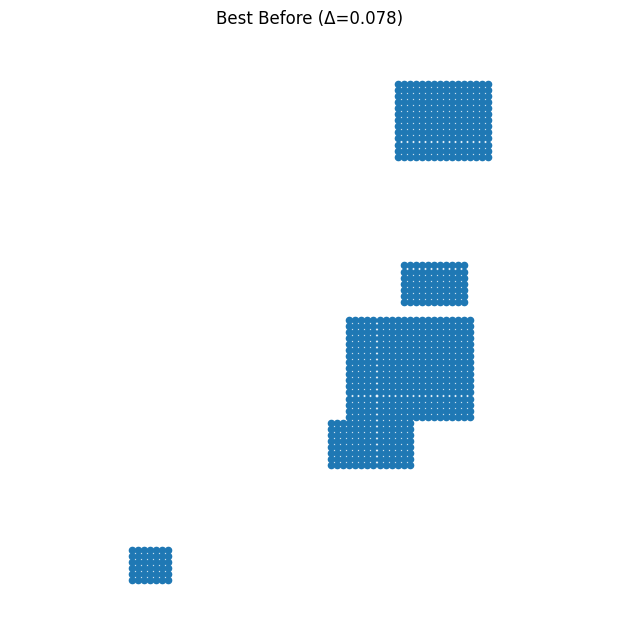

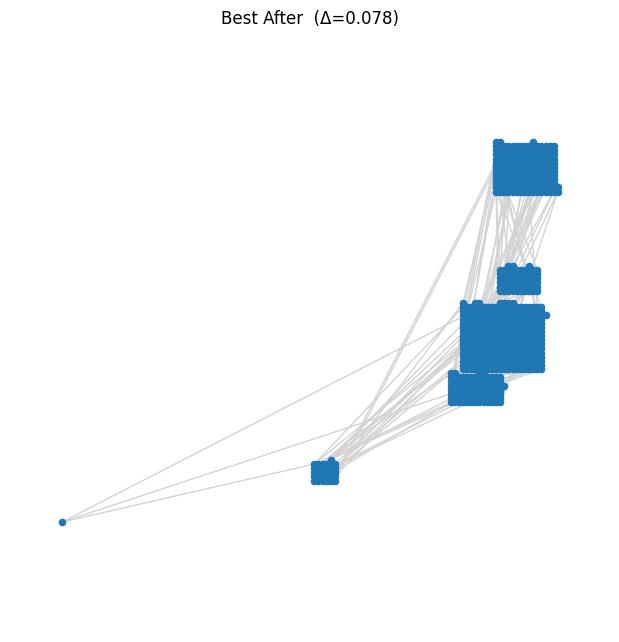


Built 50 tokenized graphs, top 25%:
 score=0.627, tokens len=778128
 score=0.620, tokens len=676866
 score=0.614, tokens len=628881
 score=0.600, tokens len=678030
 score=0.598, tokens len=442270
 score=0.598, tokens len=453628
 score=0.589, tokens len=537166
 score=0.582, tokens len=364231
 score=0.577, tokens len=343206
 score=0.575, tokens len=247456
 score=0.574, tokens len=491536
 score=0.571, tokens len=394716


In [ ]:
"""
Version 2 – Global Top→Bottom & Left→Right Only

- Boundary pools:

  - One list of top edges and one list of bottom edges (across all rectangles).

  - One list of left edges and one list of right edges.

- Pairing strategy:

  - Shuffle tops and bottoms separately, then zip them to form up to N_HORIZONTAL_GLUINGS top→bottom pairs.

  - Similarly shuffle and zip lefts with rights for up to N_VERTICAL_GLUINGS left→right pairs.

- Edge reuse:

  - Each boundary edge appears exactly once in its list, so once paired it’s never used again in that call.

- Inter‑rectangle:

  - Still allows matching between edges of different rectangles.

- Merge operation:

  - Same vertex identification merge as V1.
"""

import math
import random
import itertools
import collections
from dataclasses import dataclass, field
from typing import List, Tuple, Dict, Set, Optional

import networkx as nx
import matplotlib.pyplot as plt

# ==============================
# CONFIG / PARAMETERS
# ==============================
SEED = 42
random.seed(SEED)

# Canvas (overall coordinate grid) size
CANVAS_WIDTH = 150
CANVAS_HEIGHT = 150

# Number of rectangular subgraphs (rectangles of tiles) to generate
N_RECTANGLES = 5

# Rectangle side ranges (in # of tiles)
MIN_SIDE = 5
MAX_SIDE = 20

# Radius r for local isomorphism scoring (ball radius in graph distance)
RADIUS = 2

# Number of random gluings to attempt for horizontal and vertical boundaries
N_HORIZONTAL_GLUINGS = 30
N_VERTICAL_GLUINGS   = 30

# Whether to visualize intermediate steps
VISUALIZE = True


# ==============================
# DATA STRUCTURES
# ==============================

@dataclass
class Tile:
    """
    A tile is a unit square in Z^2 with 4 directed-cyclically ordered vertices:
      (top-left, top-right, bottom-right, bottom-left)
    We store the vertex ids (integers). Geometry (x,y) is maintained separately.
    """
    vertices: Tuple[int, int, int, int]
    coord: Tuple[int, int]      # lattice-coordinate of this tile


@dataclass
class RectangleSubgraph:
    """
    Represents a rectangular collection of tiles (w x h).
    origin: (x0, y0) tile coordinate of its top-left tile within global canvas.
    """
    tiles: List[Tile]
    width: int
    height: int
    origin: Tuple[int, int]
    id: int


@dataclass
class GluingRecord:
    """
    Keep track of which tile-edges were glued.
    Each edge described by (tile_a, tile_b, edge_type, old_edge endpoints, new_edge endpoints).
    """
    tile_a: int
    tile_b: int
    edge_type: str   # 'horizontal' or 'vertical'
    old_edge_a: Tuple[int, int]
    old_edge_b: Tuple[int, int]
    new_edge: Tuple[int, int]


# ==============================
# SOFIC APPROXIMATION CLASS
# ==============================

class SoficApproximation:
    def __init__(self):
        # list of rectangles
        self.rectangles: List[RectangleSubgraph] = []
        # global flat list of tiles
        self.tiles: List[Tile] = []
        # maps vertex_id -> (x,y) for plotting
        self.vertex_positions: Dict[int, Tuple[float, float]] = {}
        self.next_vid = 1
        self.gluings: List[GluingRecord] = []

    # -- Vertex creation / reuse inside one rectangle --
    def _new_vertex(self, x: float, y: float) -> int:
        vid = self.next_vid
        self.next_vid += 1
        self.vertex_positions[vid] = (x, y)
        return vid

    def _ensure_vertex(self, local_map: Dict[Tuple[float, float], int], x: float, y: float) -> int:
        """
        Inside one rectangle, adjacent tiles share corners.
        Reuse if already created for these coords, else new.
        """
        key = (x, y)
        if key in local_map:
            return local_map[key]
        vid = self._new_vertex(x, y)
        local_map[key] = vid
        return vid

    def add_rectangle(self, rect_id: int, origin: Tuple[int, int], w: int, h: int):
        """
        Build a w x h block of tiles anchored at 'origin' in global tile coords.
        Each lattice point (corner) becomes a vertex shared within that rectangle.
        Different rectangles do NOT share vertices initially.
        """
        ox, oy = origin
        local_map: Dict[Tuple[float, float], int] = {}
        tiles: List[Tile] = []
        for dy in range(h):
            for dx in range(w):
                gx, gy = ox + dx, oy + dy
                tl = self._ensure_vertex(local_map, gx,   gy)
                tr = self._ensure_vertex(local_map, gx+1, gy)
                br = self._ensure_vertex(local_map, gx+1, gy+1)
                bl = self._ensure_vertex(local_map, gx,   gy+1)
                tiles.append(Tile(vertices=(tl, tr, br, bl), coord=(gx, gy)))
        # register
        self.rectangles.append(RectangleSubgraph(tiles=tiles, width=w, height=h, origin=origin, id=rect_id))
        self.tiles.extend(tiles)

    # -- Extract boundary edges of a rectangle --
    def rectangle_boundary_edges(self, rect: RectangleSubgraph):
        """
        Return four lists of boundary edges for this rectangle:
          top, bottom, left, right
        Each entry: (global_tile_idx, edge_name, (v1,v2))
        """
        base = self.tiles.index(rect.tiles[0])
        coord_to_idx = {t.coord: i for i, t in enumerate(rect.tiles)}
        top, bottom, left, right = [], [], [], []
        for i, tile in enumerate(rect.tiles):
            idx = base + i
            tl, tr, br, bl = tile.vertices
            x, y = tile.coord
            # if no tile above, top edge
            if (x, y-1) not in coord_to_idx:
                top.append((idx, 'top', (tl, tr)))
            # below
            if (x, y+1) not in coord_to_idx:
                bottom.append((idx, 'bottom', (bl, br)))
            # left
            if (x-1, y) not in coord_to_idx:
                left.append((idx, 'left', (tl, bl)))
            # right
            if (x+1, y) not in coord_to_idx:
                right.append((idx, 'right', (tr, br)))
        return top, bottom, left, right

    def collect_all_boundary_edges(self):
        all_t, all_b, all_l, all_r = [], [], [], []
        for rect in self.rectangles:
            t, b, l, r = self.rectangle_boundary_edges(rect)
            all_t.extend(t); all_b.extend(b); all_l.extend(l); all_r.extend(r)
        return all_t, all_b, all_l, all_r

    # -- Vertex identification (merge) --
    def _identify_vertex(self, old_vid: int, new_vid: int):
        """
        Merge every occurrence of old_vid into new_vid in all tiles,
        then remove old_vid from vertex_positions.
        """
        if old_vid == new_vid:
            return
        for tile in self.tiles:
            vs = list(tile.vertices)
            changed = False
            for j, v in enumerate(vs):
                if v == old_vid:
                    vs[j] = new_vid
                    changed = True
            if changed:
                tile.vertices = tuple(vs)
        # drop old
        self.vertex_positions.pop(old_vid, None)

    # -- Glue by identification, only top↔bottom & left↔right --
    def glue_pairs_identify(self, pairs: List[Tuple], edge_type: str):
        for (a_idx, a_name, (a1, a2)), (b_idx, b_name, (b1, b2)) in pairs:
            # skip self
            if a_idx == b_idx:
                continue
            # always identify b→a so we fill in missing neighbor
            self._identify_vertex(b1, a1)
            self._identify_vertex(b2, a2)
            self.gluings.append(GluingRecord(
                tile_a=a_idx, tile_b=b_idx, edge_type=edge_type,
                old_edge_a=(a1, a2), old_edge_b=(b1, b2),
                new_edge=(a1, a2)
            ))

    def perform_random_gluings(self, n_horiz: int, n_vert: int):
        # collect separate pools
        tops, bottoms, lefts, rights = self.collect_all_boundary_edges()
        random.shuffle(tops);     random.shuffle(bottoms)
        random.shuffle(lefts);    random.shuffle(rights)
        # only match top↔bottom, left↔right
        nh = min(n_horiz, len(tops), len(bottoms))
        nv = min(n_vert, len(lefts), len(rights))
        horiz_pairs = [(tops[i], bottoms[i]) for i in range(nh)]
        vert_pairs  = [(lefts[i], rights[i])   for i in range(nv)]
        self.glue_pairs_identify(horiz_pairs, 'horizontal')
        self.glue_pairs_identify(vert_pairs,  'vertical')

    # -- Build networkx graph --
    def to_graph(self) -> nx.Graph:
        G = nx.Graph()
        for vid, pos in self.vertex_positions.items():
            G.add_node(vid, pos=pos)
        for tile in self.tiles:
            v = tile.vertices
            edges = [(v[0],v[1]), (v[1],v[2]), (v[2],v[3]), (v[3],v[0])]
            for u,w in edges:
                G.add_edge(u, w)
        return G


# ==============================
# GENERATION OF RANDOM RECTANGLES
# ==============================

def generate_random_rectangles(sa: SoficApproximation):
    placed = 0
    attempts = 0
    while placed < N_RECTANGLES and attempts < 500:
        attempts += 1
        w = random.randint(MIN_SIDE, MAX_SIDE)
        h = random.randint(MIN_SIDE, MAX_SIDE)
        ox = random.randint(0, CANVAS_WIDTH - w - 1)
        oy = random.randint(0, CANVAS_HEIGHT - h - 1)
        sa.add_rectangle(rect_id=placed, origin=(ox, oy), w=w, h=h)
        placed += 1
    if placed < N_RECTANGLES:
        print("Warning: could not place all rectangles.")


# ==============================
# BUILD THE IDEAL Z^2 BALL FOR SCORING
# ==============================

def build_Z2_ball_graph(radius: int) -> nx.Graph:
    G = nx.Graph()
    for x in range(-radius, radius+1):
        for y in range(-radius, radius+1):
            if abs(x) + abs(y) <= radius:
                G.add_node((x,y))
    for x,y in list(G.nodes):
        for dx,dy in [(1,0),(-1,0),(0,1),(0,-1)]:
            if (x+dx,y+dy) in G:
                G.add_edge((x,y),(x+dx,y+dy))
    return G

Z2_MODEL_BALL = build_Z2_ball_graph(RADIUS)

def canonical_form(sub: nx.Graph) -> Tuple[int]:
    degs = sorted(d for _,d in sub.degree())
    return tuple(degs)

MODEL_CANON = canonical_form(Z2_MODEL_BALL)

def extract_ball(G: nx.Graph, center: int, radius: int) -> nx.Graph:
    nodes = nx.single_source_shortest_path_length(G, center, cutoff=radius).keys()
    return G.subgraph(nodes).copy()

def is_locally_Z2(G: nx.Graph, v: int, radius: int) -> bool:
    ball = extract_ball(G, v, radius)
    if canonical_form(ball) != MODEL_CANON:
        return False
    matcher = nx.isomorphism.GraphMatcher(ball, Z2_MODEL_BALL)
    return matcher.is_isomorphic()

def score_graph_Z2_like(G: nx.Graph, radius: int) -> float:
    good = sum(1 for v in G.nodes if is_locally_Z2(G, v, radius))
    return good / G.number_of_nodes() if G.number_of_nodes() else 0.0


# ==============================
# VISUALIZATION
# ==============================

def plot_graph(G: nx.Graph, title: str, highlight: Optional[Set[int]] = None):
    pos = {n: G.nodes[n].get('pos', (random.random(), random.random()))
           for n in G.nodes}
    plt.figure(figsize=(6,6))
    nx.draw(G, pos,
            node_size=20,
            edge_color='lightgray',
            with_labels=False)
    if highlight:
        nx.draw_networkx_nodes(G, pos,
                               nodelist=list(highlight),
                               node_color='red',
                               node_size=40)
    plt.title(title)
    plt.axis('equal')
    plt.show()


# ==============================
# PIPELINE: SINGLE SAMPLE
# ==============================

def generate_sample(glue_h=N_HORIZONTAL_GLUINGS,
                    glue_v=N_VERTICAL_GLUINGS,
                    visualize=VISUALIZE):
    sa = SoficApproximation()
    generate_random_rectangles(sa)
    G0 = sa.to_graph()
    score0 = score_graph_Z2_like(G0, RADIUS)
    if visualize:
        plot_graph(G0, f"Before gluing  (score={score0:.3f})")

    sa.perform_random_gluings(glue_h, glue_v)
    G1 = sa.to_graph()
    # reassign pos
    for n in G1.nodes:
        if n in sa.vertex_positions:
            G1.nodes[n]['pos'] = sa.vertex_positions[n]
    score1 = score_graph_Z2_like(G1, RADIUS)
    if visualize:
        plot_graph(G1, f"After gluing   (score={score1:.3f})")

    return {
        'sofic': sa,
        'graph_before': G0,
        'graph_after': G1,
        'score_before': score0,
        'score_after': score1
    }


# ==============================
# PIPELINE: MULTIPLE SAMPLES
# ==============================

def generate_dataset(n_samples: int,
                     glue_horizontal=N_HORIZONTAL_GLUINGS,
                     glue_vertical=N_VERTICAL_GLUINGS,
                     visualize_best: bool = True):
    samples = []
    best_idx   = None
    best_delta = -float('inf')

    for i in range(n_samples):
        res = generate_sample(glue_horizontal, glue_vertical, visualize=False)
        samples.append(res)

        sb = res['score_before']
        sa = res['score_after']
        delta = sa - sb

        print(f"Sample {i}: before={sb:.3f}, after={sa:.3f}, Δ={delta:.3f}")

        if delta > best_delta:
            best_delta = delta
            best_idx   = i

    if visualize_best and best_idx is not None:
        b = samples[best_idx]
        sb = b['score_before']
        sa = b['score_after']
        print(f"\nBest sample #{best_idx}: before={sb:.3f}, after={sa:.3f}, Δ={best_delta:.3f}")
        plot_graph(b['graph_before'], f"Best Before (Δ={best_delta:.3f})")
        plot_graph(b['graph_after'],  f"Best After  (Δ={best_delta:.3f})")

    return samples




# ==============================
# SERIALIZATION FOR PATTERNBOOST
# ==============================

def adjacency_matrix_encoding(G: nx.Graph):
    order = sorted(G.nodes)
    idx = {v:i for i,v in enumerate(order)}
    n = len(order)
    mat = [[0]*n for _ in range(n)]
    for u,v in G.edges:
        i,j = idx[u], idx[v]
        mat[i][j] = mat[j][i] = 1
    return order, mat

def matrix_to_token_string(mat: List[List[int]]) -> str:
    n = len(mat)
    bits = []
    for i in range(n):
        for j in range(i+1, n):
            bits.append(str(mat[i][j]))
    return ''.join(bits)

def build_patternboost_dataset(samples):
    dataset = []
    for res in samples:
        G = res['graph_after']
        _, mat = adjacency_matrix_encoding(G)
        tokens = matrix_to_token_string(mat)
        dataset.append({'tokens': tokens, 'score': res['score_after']})
    return dataset


# ==============================
# MAIN
# ==============================
if __name__ == "__main__":
    N_SAMPLES = 50
    samples = generate_dataset(N_SAMPLES)
    ds = build_patternboost_dataset(samples)
    print(f"\nBuilt {len(ds)} tokenized graphs, top 25%:")
    ds_sorted = sorted(ds, key=lambda x: x['score'], reverse=True)
    topn = max(1, len(ds)//4)
    for d in ds_sorted[:topn]:
        print(f" score={d['score']:.3f}, tokens len={len(d['tokens'])}")


### Version 3: Per-Rectangle Toroidal Wrap

Sample 0: before=0.341, after=0.362, Δ=0.020
Sample 1: before=0.359, after=0.376, Δ=0.017
Sample 2: before=0.450, after=0.465, Δ=0.016
Sample 3: before=0.518, after=0.531, Δ=0.013
Sample 4: before=0.480, after=0.497, Δ=0.017
Sample 5: before=0.466, after=0.482, Δ=0.016
Sample 6: before=0.562, after=0.573, Δ=0.010
Sample 7: before=0.423, after=0.440, Δ=0.017
Sample 8: before=0.541, after=0.553, Δ=0.012
Sample 9: before=0.507, after=0.520, Δ=0.013
Sample 10: before=0.335, after=0.355, Δ=0.020
Sample 11: before=0.467, after=0.481, Δ=0.015
Sample 12: before=0.496, after=0.510, Δ=0.014
Sample 13: before=0.586, after=0.595, Δ=0.009
Sample 14: before=0.460, after=0.479, Δ=0.018
Sample 15: before=0.409, after=0.425, Δ=0.017
Sample 16: before=0.514, after=0.526, Δ=0.012
Sample 17: before=0.544, after=0.552, Δ=0.008
Sample 18: before=0.510, after=0.522, Δ=0.012
Sample 19: before=0.382, after=0.398, Δ=0.016
Sample 20: before=0.404, after=0.429, Δ=0.024
Sample 21: before=0.488, after=0.502, Δ=0.01

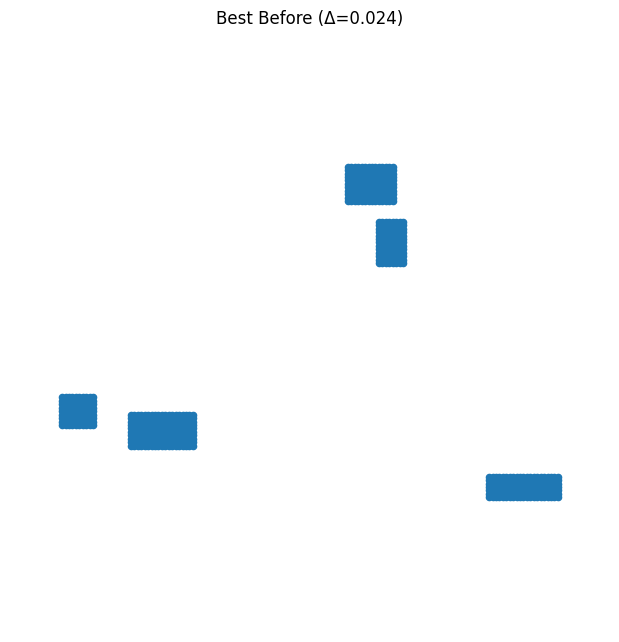

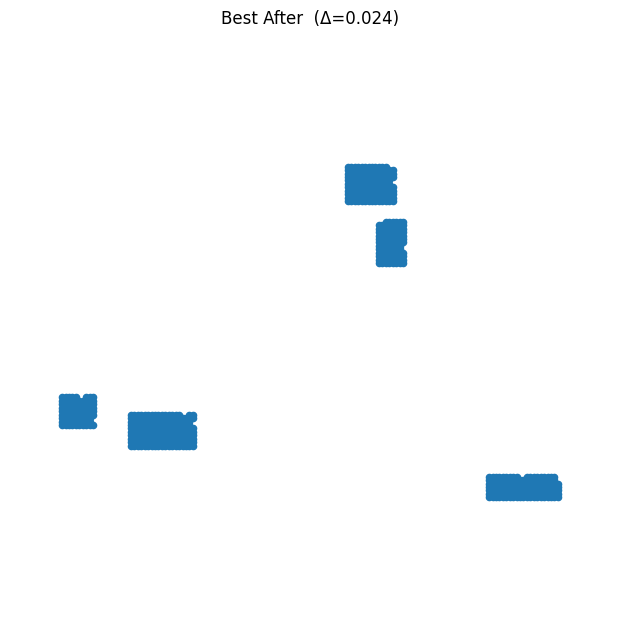

In [ ]:
"""
Version 3 – Per‑Rectangle Toroidal Wrap

- Boundary pools:

  - For each rectangle individually, collect its own top, bottom, left, and right edges.

- Pairing strategy:

  - Within each rectangle, shuffle its top & bottom lists and glue exactly one random top→bottom.

  - Likewise, glue exactly one random left→right.

- Edge reuse:

  - Only a single pair per side per rectangle—no possibility to pair the same edge twice in that call.

- Inter‑rectangle:

  - No matching across rectangles; all gluings stay within the same rectangle’s boundary.

- Merge operation:

  - Again, uses vertex identification identical to V1/V2.


"""


import math
import random
import itertools
import collections
from dataclasses import dataclass, field
from typing import List, Tuple, Dict, Set, Optional

import networkx as nx
import matplotlib.pyplot as plt

# ==============================
# CONFIG / PARAMETERS
# ==============================
SEED = 42
random.seed(SEED)

CANVAS_WIDTH = 150
CANVAS_HEIGHT = 150

N_RECTANGLES = 5
MIN_SIDE = 5
MAX_SIDE = 20

RADIUS = 2
VISUALIZE = True

# ==============================
# DATA STRUCTURES
# ==============================
@dataclass
class Tile:
    vertices: Tuple[int, int, int, int]
    coord: Tuple[int, int]

@dataclass
class RectangleSubgraph:
    tiles: List[Tile]
    width: int
    height: int
    origin: Tuple[int, int]
    id: int

@dataclass
class GluingRecord:
    tile_a: int
    tile_b: int
    edge_type: str
    old_edge_a: Tuple[int, int]
    old_edge_b: Tuple[int, int]
    new_edge: Tuple[int, int]

# ==============================
# SOFIC APPROXIMATION CLASS
# ==============================
class SoficApproximation:
    def __init__(self):
        self.rectangles: List[RectangleSubgraph] = []
        self.tiles: List[Tile] = []
        self.vertex_positions: Dict[int, Tuple[float, float]] = {}
        self.next_vid = 1
        self.gluings: List[GluingRecord] = []

    def _new_vertex(self, x: float, y: float) -> int:
        vid = self.next_vid
        self.next_vid += 1
        self.vertex_positions[vid] = (x, y)
        return vid

    def _ensure_vertex(self, local_map: Dict[Tuple[float, float], int], x: float, y: float) -> int:
        key = (x, y)
        if key in local_map:
            return local_map[key]
        vid = self._new_vertex(x, y)
        local_map[key] = vid
        return vid

    def add_rectangle(self, rect_id: int, origin: Tuple[int, int], w: int, h: int):
        ox, oy = origin
        local_map: Dict[Tuple[float, float], int] = {}
        tiles: List[Tile] = []
        for dy in range(h):
            for dx in range(w):
                gx, gy = ox + dx, oy + dy
                tl = self._ensure_vertex(local_map, gx,   gy)
                tr = self._ensure_vertex(local_map, gx+1, gy)
                br = self._ensure_vertex(local_map, gx+1, gy+1)
                bl = self._ensure_vertex(local_map, gx,   gy+1)
                tiles.append(Tile(vertices=(tl, tr, br, bl), coord=(gx, gy)))
        self.rectangles.append(RectangleSubgraph(tiles=tiles, width=w, height=h, origin=origin, id=rect_id))
        self.tiles.extend(tiles)

    def rectangle_boundary_edges(self, rect: RectangleSubgraph):
        base = self.tiles.index(rect.tiles[0])
        coord_to_idx = {t.coord: i for i, t in enumerate(rect.tiles)}
        top, bottom, left, right = [], [], [], []
        for i, tile in enumerate(rect.tiles):
            idx = base + i
            tl, tr, br, bl = tile.vertices
            x, y = tile.coord
            if (x, y-1) not in coord_to_idx:
                top.append((idx, 'top', (tl, tr)))
            if (x, y+1) not in coord_to_idx:
                bottom.append((idx, 'bottom', (bl, br)))
            if (x-1, y) not in coord_to_idx:
                left.append((idx, 'left', (tl, bl)))
            if (x+1, y) not in coord_to_idx:
                right.append((idx, 'right', (tr, br)))
        return top, bottom, left, right

    def _identify_vertex(self, old_vid: int, new_vid: int):
        if old_vid == new_vid:
            return
        for tile in self.tiles:
            vs = list(tile.vertices)
            if old_vid in vs:
                vs = [new_vid if v == old_vid else v for v in vs]
                tile.vertices = tuple(vs)
        self.vertex_positions.pop(old_vid, None)

    def glue_pairs_identify(self, pairs: List[Tuple], edge_type: str):
        for (a_idx, a_name, (a1, a2)), (b_idx, b_name, (b1, b2)) in pairs:
            if a_idx == b_idx:
                continue
            # merge b->a to fill missing neighbor
            self._identify_vertex(b1, a1)
            self._identify_vertex(b2, a2)
            self.gluings.append(GluingRecord(
                tile_a=a_idx, tile_b=b_idx,
                edge_type=edge_type,
                old_edge_a=(a1, a2),
                old_edge_b=(b1, b2),
                new_edge=(a1, a2)
            ))

    def perform_random_gluings(self):
        """
        Within each rectangle, pick one random top<->bottom
        and one random left<->right edge to glue.
        """
        for rect in self.rectangles:
            top, bottom, left, right = self.rectangle_boundary_edges(rect)
            random.shuffle(top)
            random.shuffle(bottom)
            random.shuffle(left)
            random.shuffle(right)
            # horizontal within rect
            if top and bottom:
                self.glue_pairs_identify([(top[0], bottom[0])], 'horizontal')
            # vertical within rect
            if left and right:
                self.glue_pairs_identify([(left[0], right[0])], 'vertical')

    def to_graph(self) -> nx.Graph:
        G = nx.Graph()
        for vid, pos in self.vertex_positions.items():
            G.add_node(vid, pos=pos)
        for tile in self.tiles:
            v = tile.vertices
            for u, w in [(v[0],v[1]), (v[1],v[2]), (v[2],v[3]), (v[3],v[0])]:
                G.add_edge(u, w)
        return G


# ==============================
# RANDOM RECTANGLE GENERATION
# ==============================
def generate_random_rectangles(sa: SoficApproximation):
    placed, attempts = 0, 0
    while placed < N_RECTANGLES and attempts < 500:
        attempts += 1
        w = random.randint(MIN_SIDE, MAX_SIDE)
        h = random.randint(MIN_SIDE, MAX_SIDE)
        ox = random.randint(0, CANVAS_WIDTH - w - 1)
        oy = random.randint(0, CANVAS_HEIGHT - h - 1)
        sa.add_rectangle(rect_id=placed, origin=(ox, oy), w=w, h=h)
        placed += 1
    if placed < N_RECTANGLES:
        print("Warning: placed only", placed, "rectangles.")


# ==============================
# BUILD Z^2 BALL + SCORING
# ==============================
def build_Z2_ball_graph(radius: int) -> nx.Graph:
    G = nx.Graph()
    for x in range(-radius, radius+1):
        for y in range(-radius, radius+1):
            if abs(x) + abs(y) <= radius:
                G.add_node((x,y))
    for x, y in list(G.nodes):
        for dx, dy in [(1,0),(-1,0),(0,1),(0,-1)]:
            if (x+dx,y+dy) in G:
                G.add_edge((x,y),(x+dx,y+dy))
    return G

Z2_MODEL_BALL = build_Z2_ball_graph(RADIUS)
MODEL_CANON = tuple(sorted(d for _,d in Z2_MODEL_BALL.degree()))

def extract_ball(G: nx.Graph, center: int, radius: int) -> nx.Graph:
    nodes = nx.single_source_shortest_path_length(G, center, cutoff=radius).keys()
    return G.subgraph(nodes).copy()

def is_locally_Z2(G: nx.Graph, v: int, radius: int) -> bool:
    ball = extract_ball(G, v, radius)
    if tuple(sorted(d for _,d in ball.degree())) != MODEL_CANON:
        return False
    return nx.is_isomorphic(ball, Z2_MODEL_BALL)

def score_graph_Z2_like(G: nx.Graph, radius: int) -> float:
    good = sum(1 for v in G.nodes if is_locally_Z2(G, v, radius))
    return good / G.number_of_nodes() if G.number_of_nodes() else 0.0


# ==============================
# VISUALIZATION
# ==============================
def plot_graph(G: nx.Graph, title: str, highlight: Optional[Set[int]] = None):
    pos = {n: G.nodes[n].get('pos',(random.random(),random.random())) for n in G.nodes}
    plt.figure(figsize=(6,6))
    nx.draw(G, pos, node_size=20, edge_color='lightgray', with_labels=False)
    if highlight:
        nx.draw_networkx_nodes(G, pos, nodelist=list(highlight), node_color='red', node_size=40)
    plt.title(title)
    plt.axis('equal')
    plt.show()


# ==============================
# PIPELINE: SINGLE & MULTIPLE SAMPLES
# ==============================
def generate_sample(visualize=VISUALIZE):
    sa = SoficApproximation()
    generate_random_rectangles(sa)
    G0 = sa.to_graph()
    s0 = score_graph_Z2_like(G0, RADIUS)
    if visualize:
        plot_graph(G0, f"Before (score={s0:.3f})")

    sa.perform_random_gluings()
    G1 = sa.to_graph()
    for n in G1.nodes:
        if n in sa.vertex_positions:
            G1.nodes[n]['pos'] = sa.vertex_positions[n]
    s1 = score_graph_Z2_like(G1, RADIUS)
    if visualize:
        plot_graph(G1, f"After  (score={s1:.3f})")

    return {'before': s0, 'after': s1, 'G0': G0, 'G1': G1}

def generate_dataset(n_samples: int, visualize_best: bool = True):
    samples = []
    best_idx   = None
    best_delta = -float('inf')

    for i in range(n_samples):
        res = generate_sample(visualize=False)
        samples.append(res)

        sb = res['before']
        sa = res['after']
        delta = sa - sb

        print(f"Sample {i}: before={sb:.3f}, after={sa:.3f}, Δ={delta:.3f}")

        if delta > best_delta:
            best_delta = delta
            best_idx   = i

    if visualize_best and best_idx is not None:
        b = samples[best_idx]
        sb = b['before']
        sa = b['after']
        print(f"\nBest sample #{best_idx}: before={sb:.3f}, after={sa:.3f}, Δ={best_delta:.3f}")
        plot_graph(b['G0'], f"Best Before (Δ={best_delta:.3f})")
        plot_graph(b['G1'], f"Best After  (Δ={best_delta:.3f})")

    return samples



# ==============================
# MAIN
# ==============================
if __name__ == "__main__":
    samples = generate_dataset(50)
